In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

In [4]:
nodegeo_path = 'drive/MyDrive/R/caen_nodegeo.csv'
nodegeo = pd.read_csv(nodegeo_path, delimiter=';')
nodegeo.head()

,Idw,UA_country,nb_strong,iso_un,ze,ze_name,urban_area,country,ze_ego,ze_name_ego,ua_ego,country_ego,wave,id
0,A01,"Annecy, FR",1,FR,8218.0,Annecy,Annecy,France,2502.0,Caen,Caen,France,A,1
1,A01,"Bayeux, FR",1,FR,2501.0,Bayeux,Bayeux,France,2502.0,Caen,Caen,France,A,1
2,A01,"Caen, FR",15,FR,2502.0,Caen,Caen,France,2502.0,Caen,Caen,France,A,1
3,A01,"Lyon, FR",2,FR,8214.0,Lyon,Lyon,France,2502.0,Caen,Caen,France,A,1
4,A01,"Orléans, FR",2,FR,2418.0,Orléans,Orléans,France,2502.0,Caen,Caen,France,A,1


Ex1

In [ ]:
# Loading the data
data = pd.read_csv(nodegeo_path, delimiter=';', engine='python')

# Step 1: Counting the number of individuals who responded to at least 3 waves
# 1.1 Select distinct pairs of 'id' and 'wave'
distinct_data = data[['id', 'wave']].drop_duplicates()

# 1.2 Counting the number of different waves for each individual
individual_wave_counts = distinct_data.groupby('id')['wave'].nunique()

# 1.3 Identifying individuals who responded to 3 or more waves
individuals_3_waves = individual_wave_counts[individual_wave_counts >= 3].index

# 1.4 Counting the number of such individuals
num_individuals_3_or_more = len(individuals_3_waves)

# Step 2: Counting the number of rows for each wave for these individuals
# 2.1 Filtering the original dataset for these individuals
filtered_data_for_3_waves = data[data['id'].isin(individuals_3_waves)]

# 2.2 Counting the number of rows for each wave for these individuals
wave_counts = filtered_data_for_3_waves.groupby('wave').size()

num_individuals_3_or_more, wave_counts


(66,
 wave
 A    264
 B    296
 C    405
 D    408
 F    164
 dtype: int64)

In [ ]:
# Extract the wave and id information from the 'Idw' column
nodegeo[['wave', 'id']] = nodegeo['Idw'].str.extract(r'([A-Z])(\d+)')

# Convert extracted wave and ego_id to correct data types
nodegeo['wave'] = nodegeo['wave'].astype(str)
nodegeo['id'] = nodegeo['id'].astype(int)

# Group by individual and count the number of distinct waves they appear in
individual_wave_counts = nodegeo.groupby('id')['wave'].nunique().reset_index(name='n_wave')

# Filter individuals who appear in at least 3 distinct waves
trivague_individuals = individual_wave_counts[individual_wave_counts['n_wave'] >= 3]['id']

# Filter the main dataframe to include only these individuals
trivague_nodegeo = nodegeo[nodegeo['id'].isin(trivague_individuals)]

print (trivague_individuals)


0      1
1      2
2      4
3      5
4      8
      ..
69    83
70    84
71    85
72    87
74    89
Name: id, Length: 66, dtype: int64


In [ ]:
# Group by individual and wave, then calculate the necessary metrics
network_metrics = trivague_nodegeo.groupby(['id', 'wave']).agg(
    n_places=('urban_area', 'nunique'),
    n_links=('nb_strong', 'sum')
).reset_index()

In [ ]:
# Calculate network density for each network
network_metrics['density'] = np.where(
    network_metrics['n_places'] > 1,
    2 * network_metrics['n_links'] / (network_metrics['n_places'] * (network_metrics['n_places'] - 1)),
    0
)

In [ ]:
# Group by wave and calculate mean and variance
wave_metrics = network_metrics.groupby('wave').agg(
    mean_n_places=('n_places', 'mean'),
    var_n_places=('n_places', 'var'),
    mean_n_links=('n_links', 'mean'),
    var_n_links=('n_links', 'var'),
    mean_density=('density', 'mean'),
    var_density=('density', 'var')
).reset_index()

# Display the wave_metrics for comparison
wave_metrics


,wave,mean_n_places,var_n_places,mean_n_links,var_n_links,mean_density,var_density
0,A,4.000000,4.800000,20.727273,53.647552,5.930041,37.896322
1,B,4.553846,8.782212,22.123077,82.453365,5.458937,51.921516
2,C,6.230769,10.899038,25.292308,119.241346,2.902707,21.295198
3,D,6.915254,13.940970,26.864407,135.429573,2.472811,11.047190
4,F,8.210526,14.730994,33.684211,372.116959,1.858175,4.575811


In [ ]:
import matplotlib.pyplot as plt

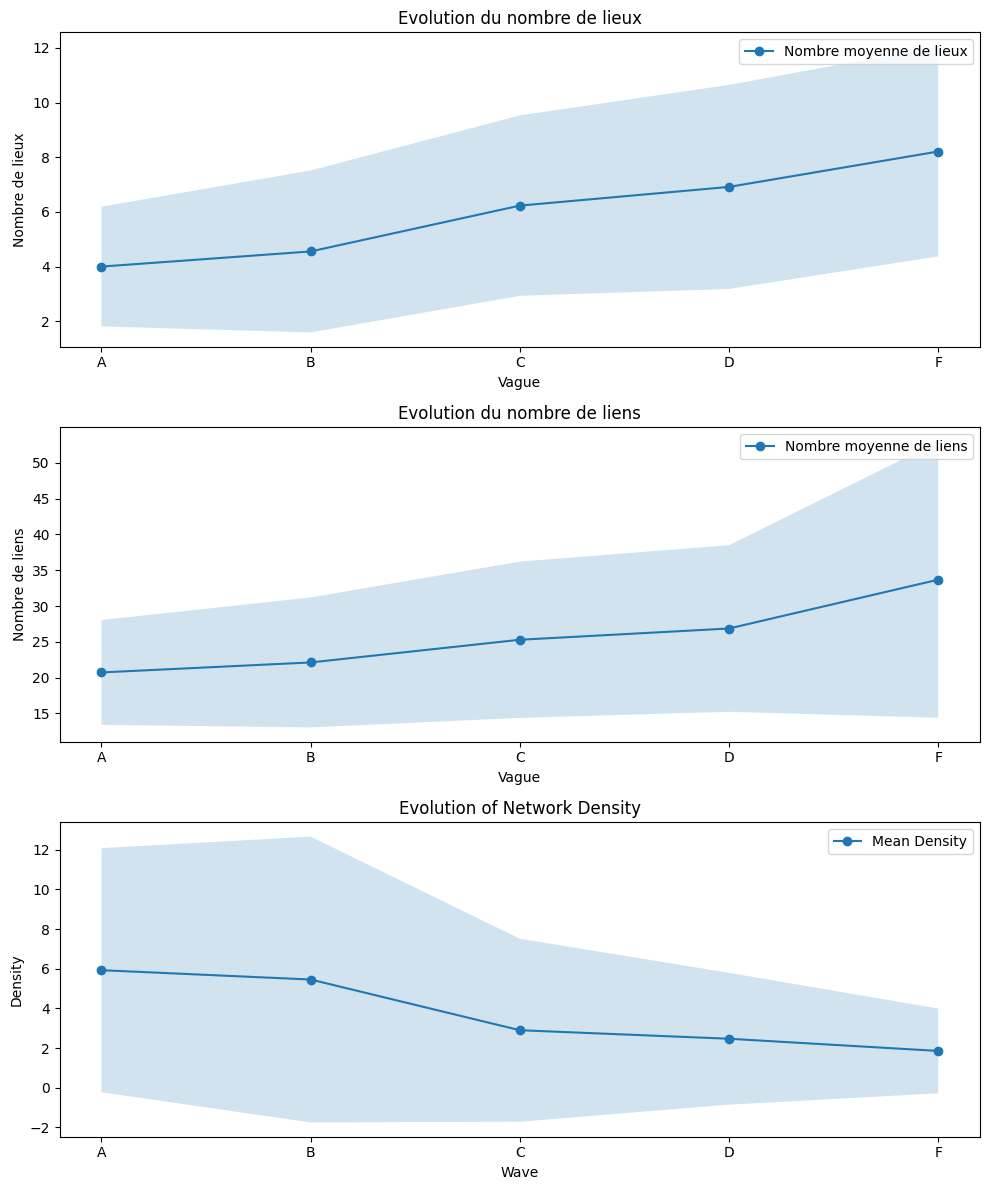

In [ ]:
# Setting up the plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Number of Places
axes[0].plot(wave_metrics['wave'], wave_metrics['mean_n_places'], label='Nombre moyenne de lieux', marker='o')
axes[0].fill_between(wave_metrics['wave'],
                     wave_metrics['mean_n_places'] - np.sqrt(wave_metrics['var_n_places']),
                     wave_metrics['mean_n_places'] + np.sqrt(wave_metrics['var_n_places']),
                     alpha=0.2)
axes[0].set_title('Evolution du nombre de lieux')
axes[0].set_xlabel('Vague')
axes[0].set_ylabel('Nombre de lieux')
axes[0].legend()

# Number of Links
axes[1].plot(wave_metrics['wave'], wave_metrics['mean_n_links'], label='Nombre moyenne de liens', marker='o')
axes[1].fill_between(wave_metrics['wave'],
                     wave_metrics['mean_n_links'] - np.sqrt(wave_metrics['var_n_links']),
                     wave_metrics['mean_n_links'] + np.sqrt(wave_metrics['var_n_links']),
                     alpha=0.2)
axes[1].set_title('Evolution du nombre de liens')
axes[1].set_xlabel('Vague')
axes[1].set_ylabel('Nombre de liens')
axes[1].legend()

# Density
axes[2].plot(wave_metrics['wave'], wave_metrics['mean_density'], label='Mean Density', marker='o')
axes[2].fill_between(wave_metrics['wave'],
                     wave_metrics['mean_density'] - np.sqrt(wave_metrics['var_density']),
                     wave_metrics['mean_density'] + np.sqrt(wave_metrics['var_density']),
                     alpha=0.2)
axes[2].set_title('Evolution of Network Density')
axes[2].set_xlabel('Wave')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()



Ex2

In [5]:
# Extract wave and ego_id information
nodegeo[['wave', 'ego_id']] = nodegeo['Idw'].str.extract(r'([A-Z])(\d+)')

# Convert extracted wave and ego_id to correct data types
nodegeo['wave'] = nodegeo['wave'].astype(str)
nodegeo['ego_id'] = nodegeo['ego_id'].astype(int)

In [ ]:
# Group by individual and count the number of distinct waves they appear in
individual_wave_counts = nodegeo.groupby('ego_id')['wave'].nunique().reset_index(name='n_wave')

# Filter individuals who appear in at least 3 distinct waves
trivague_individuals = individual_wave_counts[individual_wave_counts['n_wave'] >= 3]['ego_id']

# Filter the main dataframe to include only these individuals
trivague_nodegeo = nodegeo[nodegeo['ego_id'].isin(trivague_individuals)]

In [ ]:
# Calculate the number of places for each ego_id and wave
places_per_wave = trivague_nodegeo.groupby(['ego_id', 'wave'])['urban_area'].nunique().reset_index(name='n_places')

# Pivot the dataframe to have one row per ego_id and columns for each wave's number of places
pivot_places = places_per_wave.pivot(index='ego_id', columns='wave', values='n_places')

# Fill NaN values that may arise from pivoting (if some egos don't have entries for all waves)
pivot_places_filled = pivot_places.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

In [ ]:
# Define a function to categorize each individual based on the evolution of their network size
def categorize_individual(row):
    changes = row.diff().fillna(0)  # Calculate changes between each wave
    last_greater_first = row.iloc[-1] > row.iloc[0]
    last_less_first = row.iloc[-1] < row.iloc[0]
    last_equal_first = row.iloc[-1] == row.iloc[0]

    if changes.eq(0).all():
        return 'Stable'
    elif changes.ge(0).all() and last_greater_first:
        return 'Increasing'
    elif changes.le(0).all() and last_less_first:
        return 'Decreasing'
    elif not changes.eq(0).all():
        if last_greater_first:
            return 'Fluctuating Positive'
        elif last_less_first:
            return 'Fluctuating Negative'
        elif last_equal_first:
            return 'Fluctuating Neutral'
    return 'Undefined'

# Apply the categorization function to each row (i.e., each ego)
pivot_places_filled['category'] = pivot_places_filled.apply(categorize_individual, axis=1)

# Count the number of egos in each category
category_counts = pivot_places_filled['category'].value_counts()

category_counts


Fluctuating Positive    29
Increasing              16
Fluctuating Neutral     11
Fluctuating Negative     5
Decreasing               4
Stable                   1
Name: category, dtype: int64

In [ ]:
from networkx import Graph
import networkx as nx

# Extracting the wave identifier from the 'Idw' field
data['Wave'] = data['Idw'].str[0]

# Filtering out individuals with network size less than 3
# Counting unique 'from' and 'to' vertices for each wave and Idw
network_sizes = data.groupby(['Idw', 'Wave']).agg({'from': pd.Series.nunique, 'to': pd.Series.nunique})
network_sizes['total_size'] = network_sizes['from'] + network_sizes['to']

# Filtering data to keep only rows where total network size is 3 or more
filtered_data = data[data['Idw'].isin(network_sizes[network_sizes['total_size'] >= 3].index.get_level_values('Idw'))]

# Calculating clustering coefficient for each wave
clustering_coefficients = {}
for wave in filtered_data['Wave'].unique():
    wave_data = filtered_data[filtered_data['Wave'] == wave]

    # Creating a graph for each wave
    G = Graph()
    for _, row in wave_data.iterrows():
        # Adding an edge between 'from' and 'to' vertices
        G.add_edge(row['from'], row['to'], weight=row['w_bi'])

    # Calculating the clustering coefficient
    clustering_coefficient = nx.average_clustering(G, weight='weight')
    clustering_coefficients[wave] = clustering_coefficient

clustering_coefficients


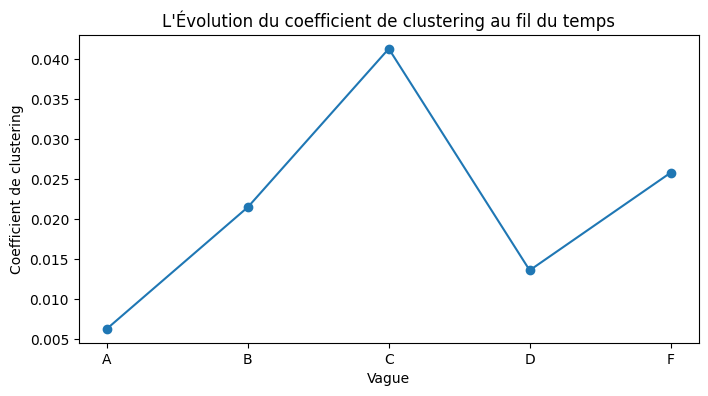

In [ ]:
import matplotlib.pyplot as plt

waves = ['A', 'B', 'C', 'D', 'F']
coefficients = [0.0063, 0.0215, 0.0413, 0.0136, 0.0258]

plt.figure(figsize=(8, 4))
plt.plot(waves, coefficients, marker='o')
plt.xlabel('Vague')
plt.ylabel('Coefficient de clustering')
plt.title("L'Évolution du coefficient de clustering au fil du temps")
plt.show()

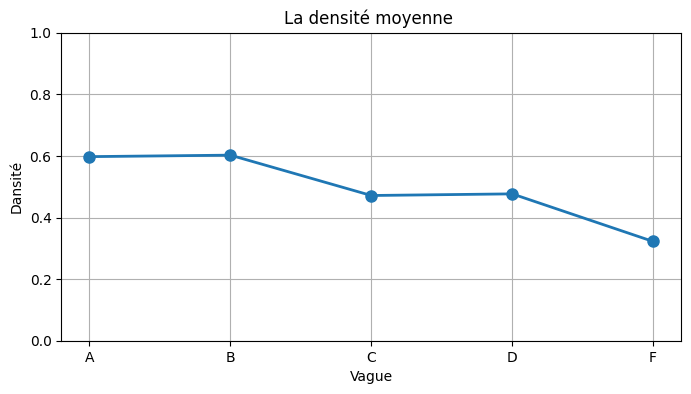

In [ ]:
import matplotlib.pyplot as plt

# Given density values for each wave
wave_densities = {
    'A': 0.5977,
    'B': 0.6025,
    'C': 0.4715,
    'D': 0.4768,
    'F': 0.3223
}

# Prepare data for plotting
waves = list(wave_densities.keys())
densities = list(wave_densities.values())

# Plotting the wave densities using plt.plot for a line graph
plt.figure(figsize=(8, 4))
plt.plot(waves, densities, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('La densité moyenne ')
plt.xlabel('Vague')
plt.ylabel('Dansité')
plt.ylim(0, 1)  # Density values range from 0 to 1
plt.grid(True)
plt.show()